LLaVA，全称 Large Language and Vision Assistant,翻译为“处理语言和视觉的大型助手”

2023年，指令微调在NLP领域已经取得比较大的进展（最典型的就是GPT）。但是在 “图像文本”的多模态任务 中，指令微调 还没有得到应用，同时也缺乏这样的 “指令微调的数据”

BLIP-2（2023多模态大语言模型）的 limitation（限制）中提到，这样的模型，在 VQA（视觉问答任务）场景下，它是缺乏上下文学习能力的------因为它的训练数据其实就是一个一个的 “图像-文本对”，也就是说，一个图像对应一个文本，不存在上下文学习的场景（换句话说，b图像只和b文本有关，b图像不和 上一个图像a和文本a 有关，同时也不和 上一个图像c和文本c 有关）

LLaVA 的作者就想构造一个上下文学习的场景，以供 多模态大语言模型 来学习

具体实现：把 “图像的描述（Caption）+ 标注框（Bounding Box，也就是边界框）” 交给 ChatGPT，来生成一系列，从简单到复杂的问答对
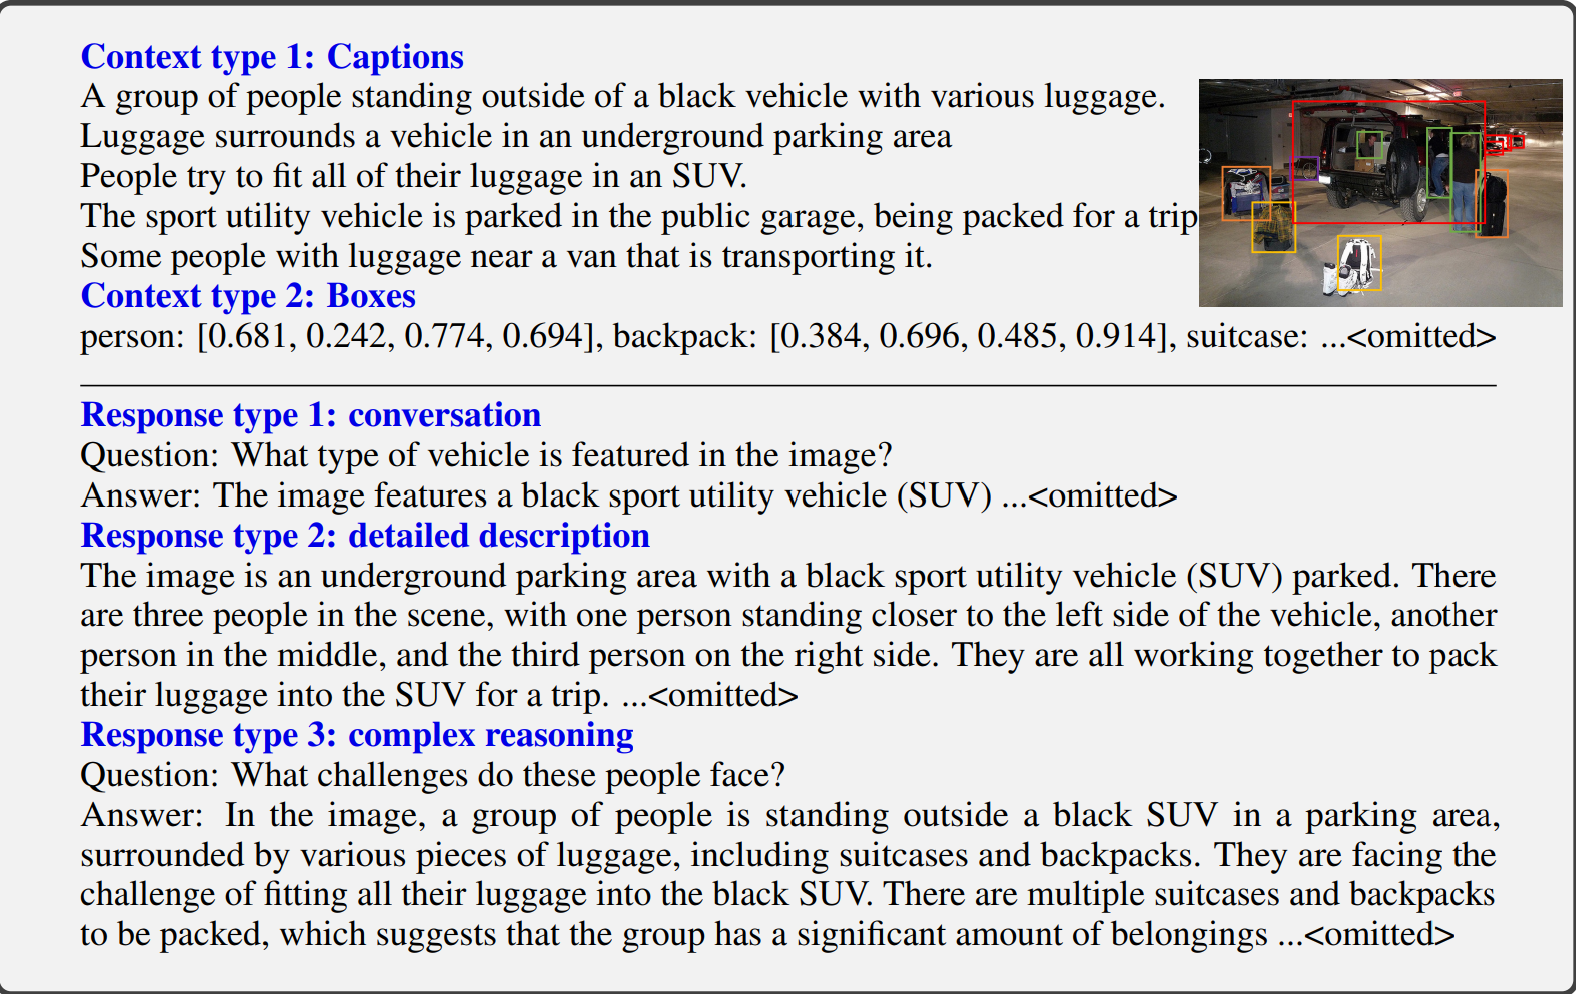
注意：作者并没有把图像也交给 ChatGPT，下图中放出来只是为了便于理解和展示

所以这就是数据集的构建过程



LLaVA 的模型结构和 BLIP-2 差不多，都是 “视觉编码器 + 大语言模型”，只是 LLaVA 把 BLIP-2 中的 Q-Former 换成了一个线性投影层
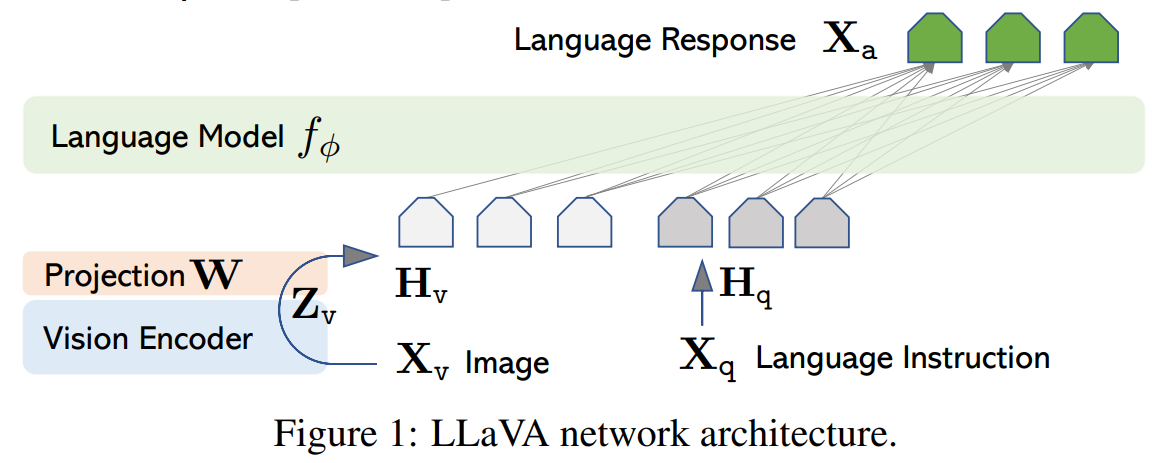

视觉编码器： 主要是 CLIP 的 ViT 模块。  
对齐层： 图像到文本对齐的矩阵 W   
语言模型： 主要是 LLaMA文本模型。  
其中，Xv表示图像，Xq表示问题，Xa表示答案  

对于Xv，进过视觉编码器：Zv=g(Xv),Zv又进一步进过一个线性层W转换为文本特征：Hv=W·Zv，便可以和文本指令特征Hq进行拼接，然后输入到语言模型中，生成答案文本Xa  
这一步“线性层转换”用来代替的是 BLIP-2 中的 Q-Former、flamingo中的门控交叉注意力机制。

training  
对于每张图像Xv，和它对应的一系列问答对(Xq1,Xa1),(Xq2,Xa2),...,(XqT,XaT)，LLaVA把它们拼接成一个长的文本序列,将所有答案视为助手的回应，并将第t轮的指令Xinstruct t 定义为：
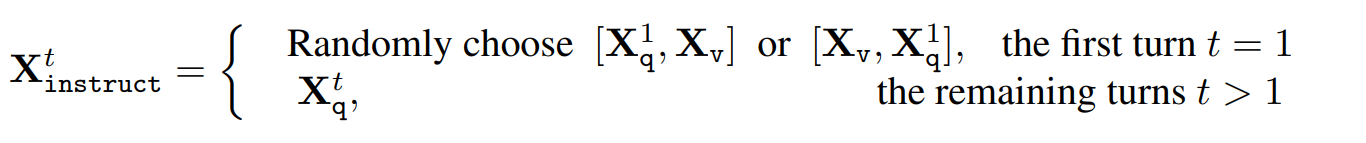  
这导致了多模态指令遵循序列的统一格式，如下图所示。我们在预测标记上对 LLM 进行指令微调，使用其原始的自回归训练目标。

自回归模型（常见的LLM）是逐 token 生成并计算损失的：模型预测下一个 token 是什么，然后和真实的 token 对比，差异就是损失。训练的目标是让模型尽可能准确地预测每一个后续 token


具体来说，对于一个长度为L的序列，我们通过以下方式计算目标答案Xa的概率：
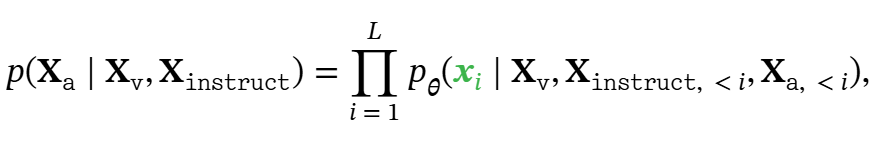  
即基于当前图像、历史指令、历史答复预测新一轮的答复，如图所示，所有答案均以该图像为依据  

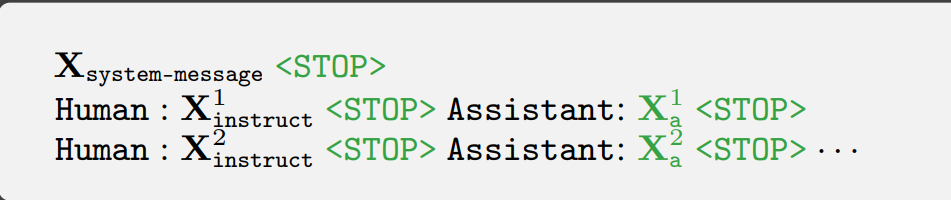  
此处仅展示了两轮对话；实际上，轮数会根据指令遵循数据的不同而变化。在我们当前的实现中，我们遵循 Vicuna-v0 [9] 来设置系统消息Xsystem-message，并将《STOP>设置为 ###。模型被训练来预测助手的回答以及停止的位置，因此在自回归模型中，仅绿色序列 / 标记被用于计算损失

Xsystem-message是一个系统指令，用于指明 LLaVA 的任务身份。其中，Xv表示图像，Xq表示问题，Xa表示答案  



【额外补充】LLaVA 的训练过程并不是只有 “指令微调” 这一个阶段，它其实进行了 两阶段的学习：

阶段1——特征对齐： 采用 “图像-文本对” 生成的有关的对话数据（过滤后的CC数据集，总共595K，无上下文场景） 来训练 W  

阶段2——指令微调： 用（ChatGPT）生成指令微调数据（有上下文场景）和ScienceQA数据集（第一个大规模的多模态科学问题数据集）来训练W和语言模型。  


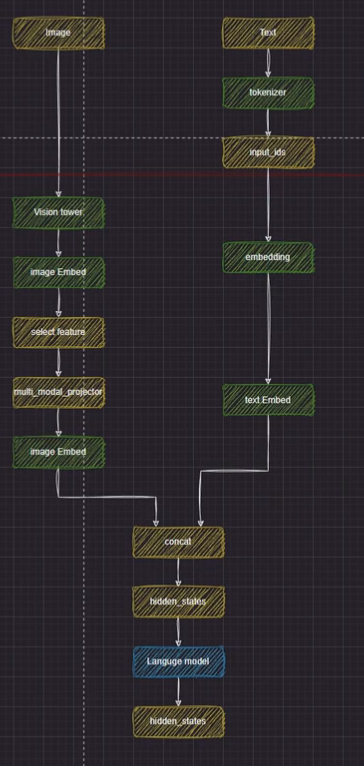  
llava处理数据的过程  
对于图像数据，图像先经过vision tower（视觉编码器）得到图像特征，之后进行特征选择，选出最重要的图像特征，然后通过线性投影层转换为文本特征，最后和文本指令拼接后输入到语言模型中  
对于文本数据，先进行tokenization（分词），转成input_ids，然后进行embedding（嵌入），最后和图像特征拼接后输入到语言模型中
输入给语言模型的是 图像特征 + 文本指令特征 的拼接的hidden state（隐藏状态），语言模型基于这个hidden state，利用generate方法生成答案文本

具体讲一下一段文字+图片的数据是怎么操作的：  
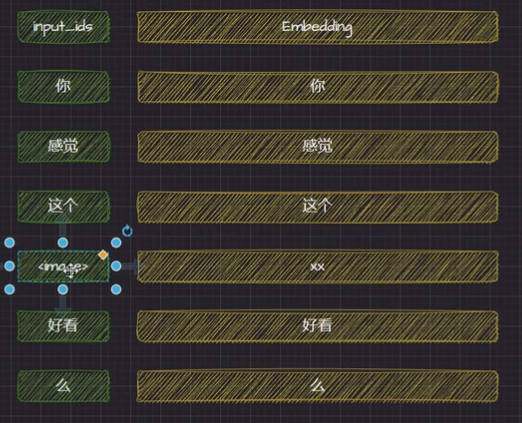 
可以看到文本数据会经过tokenization和embedding，变成文本特征，其中例如这句话，数据维度(1,6,4096)，表示batch_size=1，token数量=6，每个token的embedding维度=4096

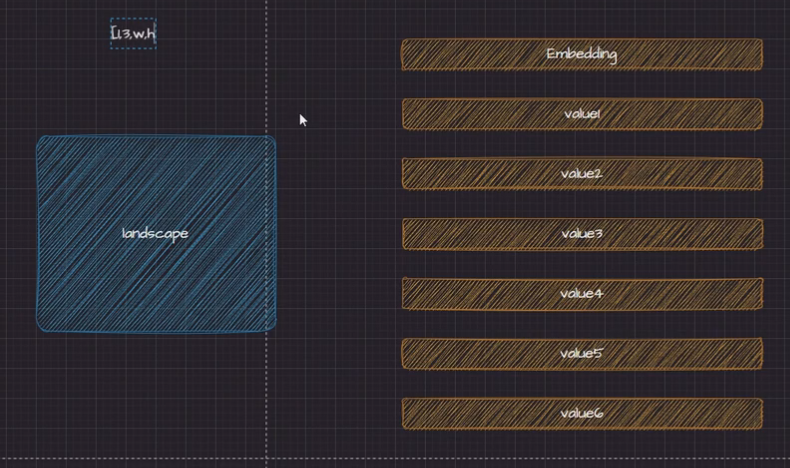
对于图像数据，输入的大小为[1,3,w,h]，分别代表 batch_size=1，3个颜色通道，宽度w，高度h，进过转换，得到[1,128,4096]，表示batch_size=1，128个图像特征，每个图像特征的维度是4096
下面就是对图像embedding和文本embedding进行拼接


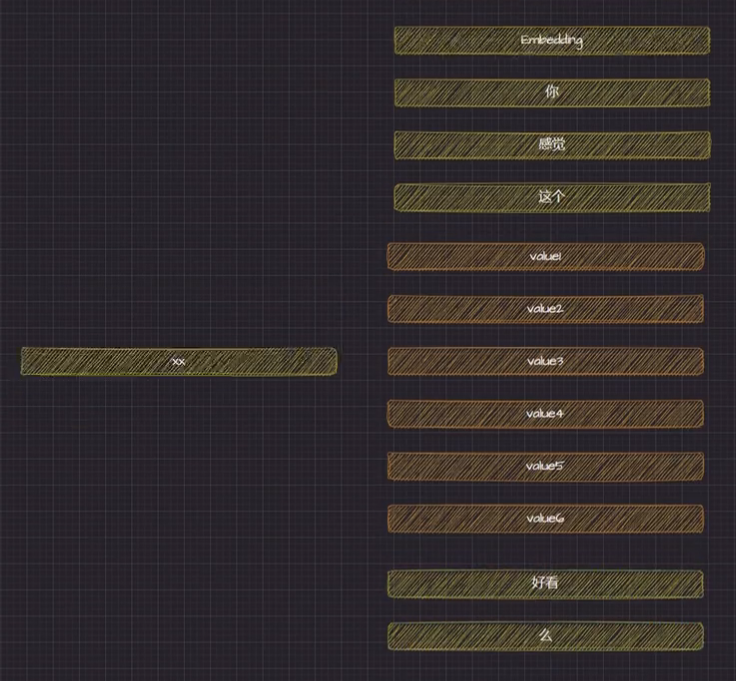
刚才提到，文本中有一个占位符，会被图像特征替换掉
最后维度就成了[1,5+128,4096]，表示batch_size=1，5个文本token + 128个图像特征，一共133个token，每个token的embedding维度是4096
这些拼接起来的就是 输入给语言模型的hidden state（隐藏状态）

输入一句话，是22个token，所以inputs_embeds.shape是[1,22,4096]

图像进过visiontower，被提取出来的特征selected_img_features.shape是[1,577,1024]，经过特定的选择，变成[1,576,1024]（为什么是576？因为这个tensor里包含了一个[CLS]token，所以要减去1）  
进过MLP投影，变成[1,576,4096]   
创建一个Masked token的embedding，shape是[1,1,4096]，用来替换文本中的占位符token，可以查看图像的Index，对应的是input_ids的第几个序号。同时可以找到非图像的token的ID，会发现占位符没有在non_image_token_ids里。  
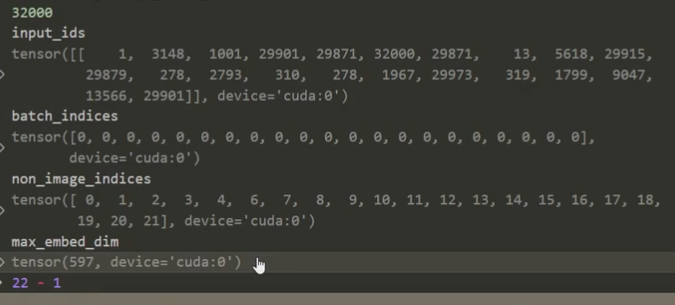  
可以查询final_embedding的内容，会看到占位符的位置的值都是0，需要被图像特征替换掉。  
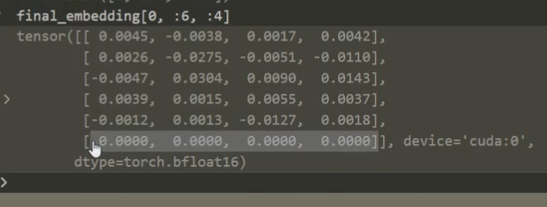

现在进行拼接，注意文字中有一位是占位符，会被图像特征替换掉，所以最终inputs_embeds.shape是[1,22-1+576,4096] = [1,597,4096]
